## Marketing Channel Attribution Using Markov Chains

#### **Markov Chains** describe a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. In the context of channel attribution, **Markov Chains** give us a framework to model user journeys and how each channel factors into the users traveling from one channel to another to eventually purchase (or not).

#### The underlying concept of **Markov chains** is that customer journey data can be processed  to identify the probabilities of moving from one event to another in a network of potential marketing channel events and conversion events.

### Mount the Google Drive where the data files are located.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the necessary Python software packages to perform the attribution analysis...

In [2]:
# !pip install ChannelAttribution

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import subprocess
from sklearn import preprocessing
import matplotlib.pyplot as plt
import ChannelAttribution as ca
plt.rc("font", size=14)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Version: 2.1.7


### Load the `Channel_attribution.csv` file



In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Marketing Channel Attribution - Markov Chains/Channel_attribution.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   R05A.01  2392 non-null   int64  
 1   R05A.02  2392 non-null   int64  
 2   R05A.03  2384 non-null   float64
 3   R05A.04  2217 non-null   float64
 4   R05A.05  1586 non-null   float64
 5   R05A.06  1030 non-null   float64
 6   R05A.07  605 non-null    float64
 7   R05A.08  391 non-null    float64
 8   R05A.09  228 non-null    float64
 9   R05A.10  138 non-null    float64
 10  R05A.11  82 non-null     float64
 11  R05A.12  52 non-null     float64
 12  R05A.13  29 non-null     float64
 13  R05A.14  19 non-null     float64
 14  R05A.15  8 non-null      float64
 15  R05A.16  7 non-null      float64
 16  R05A.17  4 non-null      float64
 17  R05A.18  2 non-null      float64
 18  R05A.19  1 non-null      float64
 19  R05A.20  1 non-null      float64
 20  Output   0 non-null      float64
dtypes: float64(19)

### Let's examine `Channel_attribution.csv`...

In [5]:
df.head()

,R05A.01,R05A.02,R05A.03,R05A.04,R05A.05,R05A.06,R05A.07,R05A.08,R05A.09,R05A.10,...,R05A.12,R05A.13,R05A.14,R05A.15,R05A.16,R05A.17,R05A.18,R05A.19,R05A.20,Output
0,16,4,3.0,5.0,10.0,8.0,6.0,8.0,13.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,9.0,10.0,1.0,4.0,3.0,21.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,13,20.0,16.0,15.0,21.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,15,20.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16,9,13.0,20.0,21.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get a list of columns in df and convert all variables to type 'str'. Also, remove any trailing '.0'

In [6]:
cols = df.columns

for col in cols:
  df[col] = df[col].astype(str)
  df[col] = df[col].map(lambda x: str(x)[:-2] if '.' in x else str(x))

In [7]:
df.head()

,R05A.01,R05A.02,R05A.03,R05A.04,R05A.05,R05A.06,R05A.07,R05A.08,R05A.09,R05A.10,...,R05A.12,R05A.13,R05A.14,R05A.15,R05A.16,R05A.17,R05A.18,R05A.19,R05A.20,Output
0,16,4,3,5,10,8,6,8,13,20,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2,1,9,10,1,4,3,21,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,9,13,20,16,15,21,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,8,15,20,21,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,16,9,13,20,21,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### We now create the Markov chain framework where user journeys are combined into a single variable of the form `Channel 1 > Channel 2 > Channel 3 > ...`

In [8]:
df['Path'] = ''  # First we create the 'Path' variable.

for i in df.index:
    # df.at[i, 'Path'] = 'Start'
    for x in cols:
        df.at[i, 'Path'] = df.at[i, 'Path'] + df.at[i, x] + ' > '  # df.at[x,y] accesses the element in the 'x'th row and 'y'th column

In [9]:
df['Path'].head()

,Path
0,16 > 4 > 3 > 5 > 10 > 8 > 6 > 8 > 13 > 20 > 21...
1,2 > 1 > 9 > 10 > 1 > 4 > 3 > 21 > nan > nan > ...
2,9 > 13 > 20 > 16 > 15 > 21 > nan > nan > nan >...
3,8 > 15 > 20 > 21 > nan > nan > nan > nan > nan...
4,16 > 9 > 13 > 20 > 21 > nan > nan > nan > nan ...


### Since Channel 21 in our dataset is a conversion event, we will separate that channel from the path and create a separate conversion variable holding the number of conversions happening (still only 1 in our user journey level data)




In [10]:
# Split path on conversion (channel 21)
df['Path'] = df['Path'].map(lambda x: x.split(' > 21')[0])

# Create conversion value we can sum to get total conversions for each path
df['Conversion'] = 1

In [11]:
df.head()

,R05A.01,R05A.02,R05A.03,R05A.04,R05A.05,R05A.06,R05A.07,R05A.08,R05A.09,R05A.10,...,R05A.14,R05A.15,R05A.16,R05A.17,R05A.18,R05A.19,R05A.20,Output,Path,Conversion
0,16,4,3,5,10,8,6,8,13,20,...,nan,nan,nan,nan,nan,nan,nan,nan,16 > 4 > 3 > 5 > 10 > 8 > 6 > 8 > 13 > 20,1
1,2,1,9,10,1,4,3,21,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,2 > 1 > 9 > 10 > 1 > 4 > 3,1
2,9,13,20,16,15,21,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,9 > 13 > 20 > 16 > 15,1
3,8,15,20,21,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,8 > 15 > 20,1
4,16,9,13,20,21,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,16 > 9 > 13 > 20,1


We’re now almost done with the initial data manipulation work. Our data still contains all the original columns, so we select the subset of columns that we need going forward. Since some users may have taken the same journey, we will group our data by unique user journeys and our conversion variable will hold the number of conversions for each respective journey.

In [12]:
# Select relevant columns
df = df[['Path', 'Conversion']]
df

,Path,Conversion
0,16 > 4 > 3 > 5 > 10 > 8 > 6 > 8 > 13 > 20,1
1,2 > 1 > 9 > 10 > 1 > 4 > 3,1
2,9 > 13 > 20 > 16 > 15,1
3,8 > 15 > 20,1
4,16 > 9 > 13 > 20,1
...,...,...
2387,4 > 4 > 5 > 12 > 13 > 2 > 20,1
2388,9 > 16 > 17 > 15 > 20,1
2389,10 > 6 > 5 > 4 > 2 > 9 > 20,1
2390,10 > 6 > 11 > 20,1


In [13]:
# Sum conversions by Path
df = df.groupby('Path').sum().reset_index()
df

,Path,Conversion
0,1 > 1 > 1 > 20,1
1,1 > 1 > 12 > 12,1
2,1 > 1 > 14 > 13 > 12 > 20,1
3,1 > 1 > 3 > 13 > 3 > 20,1
4,1 > 1 > 3 > 17 > 17,1
...,...,...
1901,9 > 9 > 4 > 3 > 9 > 20,1
1902,9 > 9 > 4 > 6 > 4,1
1903,9 > 9 > 5 > 13 > 16,1
1904,9 > 9 > 6,1


### Create the Markov Attribution Model

In [14]:
markov = ca.markov_model(df, 'Path', var_value = 'Conversion', var_conv = 'Conversion', sep = '>', order=1, out_more = True)

Number of simulations: 100000 - Convergence reached: 2.05% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (17) is reached: 99.40%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [15]:
markov.keys()

dict_keys(['result', 'transition_matrix', 'removal_effects'])

In [16]:
markov['result'], type(markov['result'])

(   channel_name  total_conversions  total_conversion_value
 0             1          82.805970               82.805970
 1            20         439.582090              439.582090
 2            12          81.253731               81.253731
 3            14          64.238806               64.238806
 4            13         197.791045              197.791045
 5             3         122.328358              122.328358
 6            17          86.985075               86.985075
 7             6          58.985075               58.985075
 8             8          60.656716               60.656716
 9            10         209.850746              209.850746
 10           11         115.402985              115.402985
 11           16         159.820896              159.820896
 12            2          97.074627               97.074627
 13            4         222.149254              222.149254
 14            7          40.597015               40.597015
 15            5          80.537313     

### Create dataframe of conversion values generated by the Markov model.

In [17]:
# Select only the necessary columns and rename them
markov_conversions = markov['result'][['channel_name','total_conversions']]
markov_conversions.columns = ['Channel', 'Conversion']
markov_conversions['Channel'] = markov_conversions['Channel'].astype(int)
markov_conversions['Attribution'] = "Markov Chain"
markov_conversions = markov_conversions[['Channel','Attribution','Conversion']]
markov_conversions = markov_conversions.sort_values(by='Channel')
markov_conversions.head()

<ipython-input-17-0d2771363704>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  markov_conversions['Channel'] = markov_conversions['Channel'].astype(int)


,Channel,Attribution,Conversion
0,1,Markov Chain,82.805970
12,2,Markov Chain,97.074627
5,3,Markov Chain,122.328358
13,4,Markov Chain,222.149254
15,5,Markov Chain,80.537313


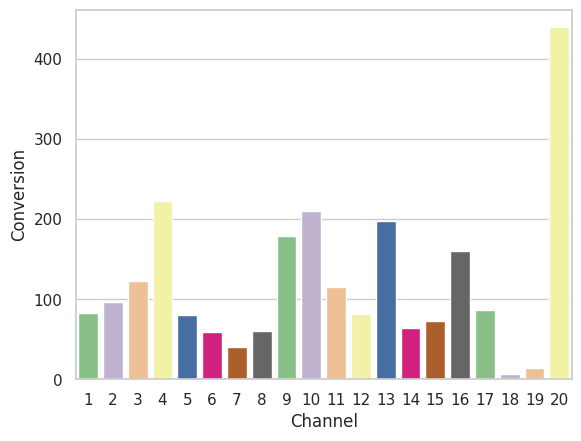

In [18]:
ax = sns.barplot(x="Channel", y="Conversion", data=markov_conversions, hue='Channel', palette="Accent", legend=False)
plt.show()

### Let's calculate conversion contribution numbers for First Touch attribution.

In [19]:
# First Touch Attribution
df['First Touch'] = df['Path'].map(lambda x: x.split(' > ')[0])  # Get first channel in path and remove '>'
df_ft = pd.DataFrame()
df_ft['Channel'] = df['First Touch']
df_ft['Attribution'] = 'First Touch'
df_ft['Conversion'] = 1
df_ft = df_ft.groupby(['Channel', 'Attribution']).sum().reset_index()
df_ft.head()

,Channel,Attribution,Conversion
0,1,First Touch,116
1,10,First Touch,440
2,11,First Touch,50
3,12,First Touch,64
4,13,First Touch,245


### Let's calculate conversion contribution numbers for Last Touch attribution.

In [20]:
# Last Touch Attribution
df['Last Touch'] = df['Path'].map(lambda x: x.split(' > ')[-1])  # Get last channel in path and remove preceding '>'
df_lt = pd.DataFrame()
df_lt['Channel'] = df['Last Touch']
df_lt['Attribution'] = 'Last Touch'
df_lt['Conversion'] = 1
df_lt = df_lt.groupby(['Channel', 'Attribution']).sum().reset_index()
df_lt.head()

,Channel,Attribution,Conversion
0,1,Last Touch,17
1,10,Last Touch,38
2,11,Last Touch,33
3,12,Last Touch,23
4,13,Last Touch,71


### Let's calculate conversion contribution numbers for Linear attribution.

In [21]:
# Linear Attribution
channel = []
conversion = []
for i in df.index:
    for j in df.at[i, 'Path'].split(' > '):   # remove the '>' between each channel to get length of journey (a list)
        # print(df.at[i, 'Path'].split(' > '))
        channel.append(j)
        conversion.append(1/len(df.at[i, 'Path'].split(' > ')))  # each channel gets assigned conversion = 1/(length of journey)
lin_att_df = pd.DataFrame()
lin_att_df['Channel'] = channel
lin_att_df['Attribution'] = 'Linear'
lin_att_df['Conversion'] = conversion
lin_att_df = lin_att_df.groupby(['Channel', 'Attribution']).sum().reset_index()
lin_att_df.head()

,Channel,Attribution,Conversion
0,1,Linear,66.873661
1,10,Linear,168.222393
2,11,Linear,88.625714
3,12,Linear,67.961197
4,13,Linear,161.356219


### Let’s merge all our 4 approaches together and evaluate the differences in outputs.

In [22]:
# Concatenate the four data frames to a single data frame
df_total_attr = pd.concat([df_ft, df_lt, lin_att_df, markov_conversions],sort=False)
df_total_attr['Channel'] = df_total_attr['Channel'].astype(int)
df_total_attr.sort_values(by='Channel', ascending=True,inplace=True)
df_total_attr.head()

,Channel,Attribution,Conversion
0,1,First Touch,116.000000
0,1,Markov Chain,82.805970
0,1,Last Touch,17.000000
0,1,Linear,66.873661
11,2,Linear,79.945001


### Let's visualize the attributions...

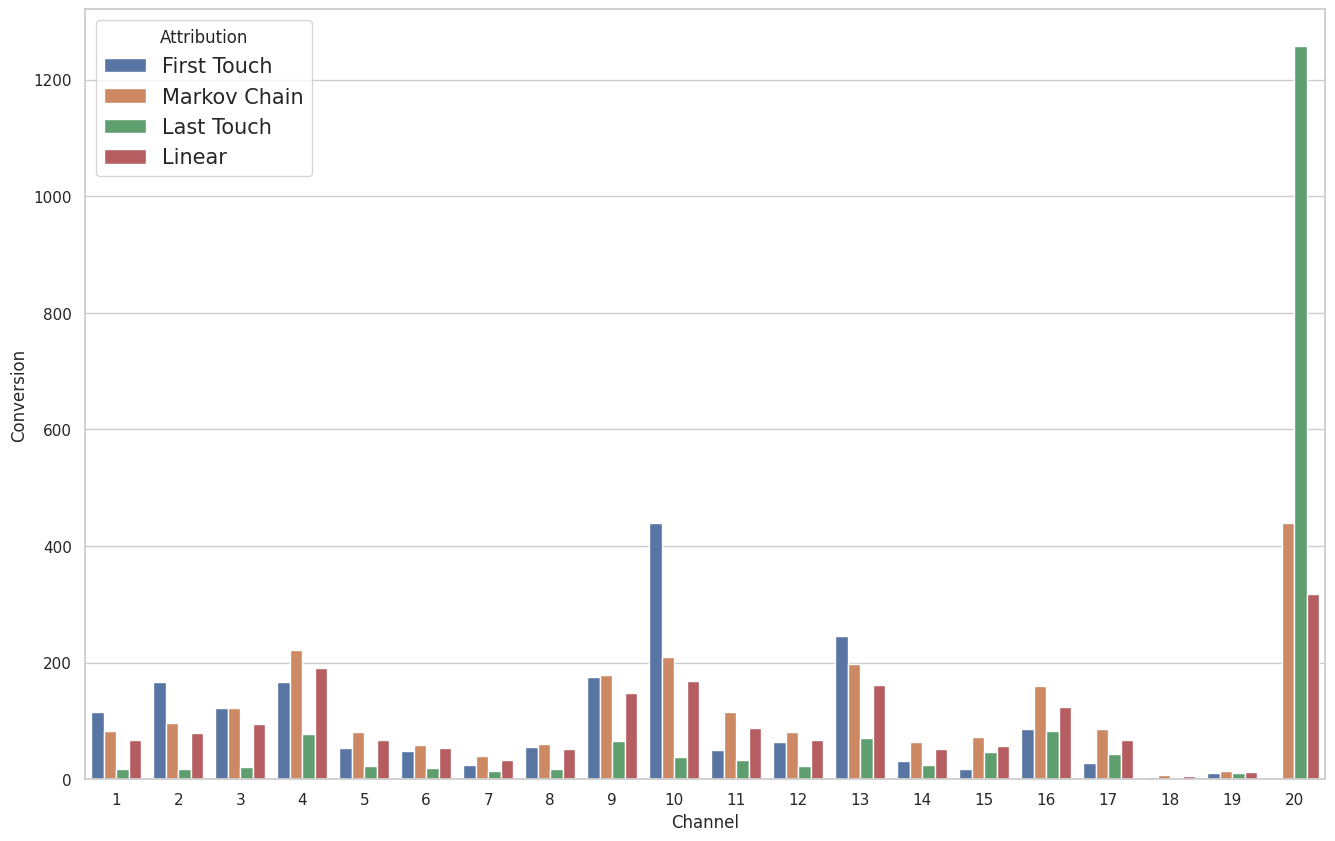

In [23]:
# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Conversion', hue='Attribution', data=df_total_attr)
plt.show()

### Looking at the above chart, we can quickly conclude that most user journeys start with Channel 10 and end with Channel 20, while no user journeys start at Channel 20.

### Get the transition probability matrix from the Markov model output.

In [24]:
trans_prob = pd.DataFrame(markov['transition_matrix'])
trans_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channel_from            393 non-null    object 
 1   channel_to              393 non-null    object 
 2   transition_probability  393 non-null    float64
dtypes: float64(1), object(2)
memory usage: 9.3+ KB


In [25]:
trans_prob.head()

,channel_from,channel_to,transition_probability
0,(start),1,0.054348
1,(start),10,0.228679
2,(start),11,0.027592
3,(start),3,0.031355
4,(start),5,0.133779


In [26]:
# Convert data to floats
trans_prob ['transition_probability'] = trans_prob ['transition_probability'].astype(float)

# Convert start and conversion event to numeric values so we can sort and iterate through
trans_prob.replace('(start)', '0', inplace=True)
trans_prob.replace('(conversion)', '21', inplace=True)
trans_prob.head()

,channel_from,channel_to,transition_probability
0,0,1,0.054348
1,0,10,0.228679
2,0,11,0.027592
3,0,3,0.031355
4,0,5,0.133779


In [27]:
# Get unique origin channels
channel_from_unique = trans_prob['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)

# Get unique destination channels
channel_to_unique = trans_prob['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

print(channel_to_unique,channel_from_unique)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'] ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


### Create the transition matrix...

In [28]:
trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)

### Assign the probabilities to the corresponding cells in our transition matrix

In [29]:
for f in channel_from_unique:
    for t in channel_to_unique:

        # get row for each unique 'to' and 'from' channel combination and set the row = x
        x = trans_prob [(trans_prob ['channel_from'] == f) & (trans_prob ['channel_to'] == t)]
        prob = x['transition_probability'].values  # pull transition probability value from x

        if prob.size > 0:
            trans_matrix[t][f] = prob[0]
        else:
            trans_matrix[t][f] = 0

<ipython-input-29-33aa2e920510>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trans_matrix[t][f] = prob[0]
<ipython-input-29-33aa2e920510>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting val

In [30]:
trans_matrix

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0.054348,0,0.031355,0.014214,0.133779,0.070234,0.01296,0.020903,0.023411,0.228679,...,0.046405,0.083194,0.096572,0.01087,0.02592,0.104515,0.009197,0.001672,0.004181,0
1,0,0.142857,0.038462,0.013736,0.043956,0.101648,0.013736,0.043956,0.054945,0.052198,...,0.043956,0.134615,0.123626,0.013736,0.024725,0.057692,0.013736,0.002747,0.008242,0.049451
2,0.006224,0,0.006224,0.005187,0.009336,0.005187,0.011929,0.004668,0.001556,0.008299,...,0.017635,0.003631,0.010373,0.001556,0.002593,0.009336,0.00778,0.001556,0.000519,0.882261
3,0.018817,0.198925,0,0.05914,0.177419,0.024194,0.051075,0.002688,0.016129,0.051075,...,0.048387,0.040323,0.094086,0.008065,0.021505,0.018817,0.02957,0.002688,0.021505,0.061828
4,0.010949,0.321168,0.025547,0,0.065693,0.018248,0.032847,0.025547,0.021898,0.021898,...,0.109489,0.007299,0.072993,0.014599,0.036496,0.051095,0.043796,0.010949,0.00365,0.091241
5,0.012739,0.219745,0.053079,0.053079,0,0.031847,0.027601,0.008493,0.019108,0.079618,...,0.123142,0.029724,0.082803,0.007431,0.023355,0.059448,0.036093,0,0.010616,0.080679
6,0.033748,0.165187,0.010657,0.024867,0.035524,0,0.015986,0.0373,0.031972,0.028419,...,0.071048,0.026643,0.193606,0.021314,0.049734,0.136767,0.015986,0.001776,0.001776,0.0373
7,0.002725,0.474114,0.016349,0.021798,0.021798,0.019074,0,0.013624,0.019074,0.027248,...,0.046322,0.013624,0.024523,0.00545,0.016349,0.021798,0.100817,0.008174,0.008174,0.128065
8,0.032258,0.086022,0.02509,0.021505,0.039427,0.053763,0.028674,0,0.043011,0.086022,...,0.039427,0.017921,0.129032,0.107527,0.064516,0.086022,0.007168,0,0,0.071685
9,0.029963,0.183521,0.05618,0.022472,0.078652,0.033708,0.018727,0.05618,0,0.048689,...,0.041199,0.033708,0.078652,0.033708,0.033708,0.089888,0.022472,0.003745,0.003745,0.06367


### Convert all probabilities to floats and # rename the start and conversion events

In [31]:
trans_matrix = trans_matrix.apply(pd.to_numeric)

trans_matrix.rename(index={'0': 'Start'}, inplace=True)
trans_matrix.rename(columns={'21': 'Conversion'}, inplace=True)
trans_matrix

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,Conversion
Start,0.054348,0.000000,0.031355,0.014214,0.133779,0.070234,0.012960,0.020903,0.023411,0.228679,...,0.046405,0.083194,0.096572,0.010870,0.025920,0.104515,0.009197,0.001672,0.004181,0.000000
1,0.000000,0.142857,0.038462,0.013736,0.043956,0.101648,0.013736,0.043956,0.054945,0.052198,...,0.043956,0.134615,0.123626,0.013736,0.024725,0.057692,0.013736,0.002747,0.008242,0.049451
2,0.006224,0.000000,0.006224,0.005187,0.009336,0.005187,0.011929,0.004668,0.001556,0.008299,...,0.017635,0.003631,0.010373,0.001556,0.002593,0.009336,0.007780,0.001556,0.000519,0.882261
3,0.018817,0.198925,0.000000,0.059140,0.177419,0.024194,0.051075,0.002688,0.016129,0.051075,...,0.048387,0.040323,0.094086,0.008065,0.021505,0.018817,0.029570,0.002688,0.021505,0.061828
4,0.010949,0.321168,0.025547,0.000000,0.065693,0.018248,0.032847,0.025547,0.021898,0.021898,...,0.109489,0.007299,0.072993,0.014599,0.036496,0.051095,0.043796,0.010949,0.003650,0.091241
5,0.012739,0.219745,0.053079,0.053079,0.000000,0.031847,0.027601,0.008493,0.019108,0.079618,...,0.123142,0.029724,0.082803,0.007431,0.023355,0.059448,0.036093,0.000000,0.010616,0.080679
6,0.033748,0.165187,0.010657,0.024867,0.035524,0.000000,0.015986,0.037300,0.031972,0.028419,...,0.071048,0.026643,0.193606,0.021314,0.049734,0.136767,0.015986,0.001776,0.001776,0.037300
7,0.002725,0.474114,0.016349,0.021798,0.021798,0.019074,0.000000,0.013624,0.019074,0.027248,...,0.046322,0.013624,0.024523,0.005450,0.016349,0.021798,0.100817,0.008174,0.008174,0.128065
8,0.032258,0.086022,0.025090,0.021505,0.039427,0.053763,0.028674,0.000000,0.043011,0.086022,...,0.039427,0.017921,0.129032,0.107527,0.064516,0.086022,0.007168,0.000000,0.000000,0.071685
9,0.029963,0.183521,0.056180,0.022472,0.078652,0.033708,0.018727,0.056180,0.000000,0.048689,...,0.041199,0.033708,0.078652,0.033708,0.033708,0.089888,0.022472,0.003745,0.003745,0.063670


### Visualize this transition matrix in a heatmap

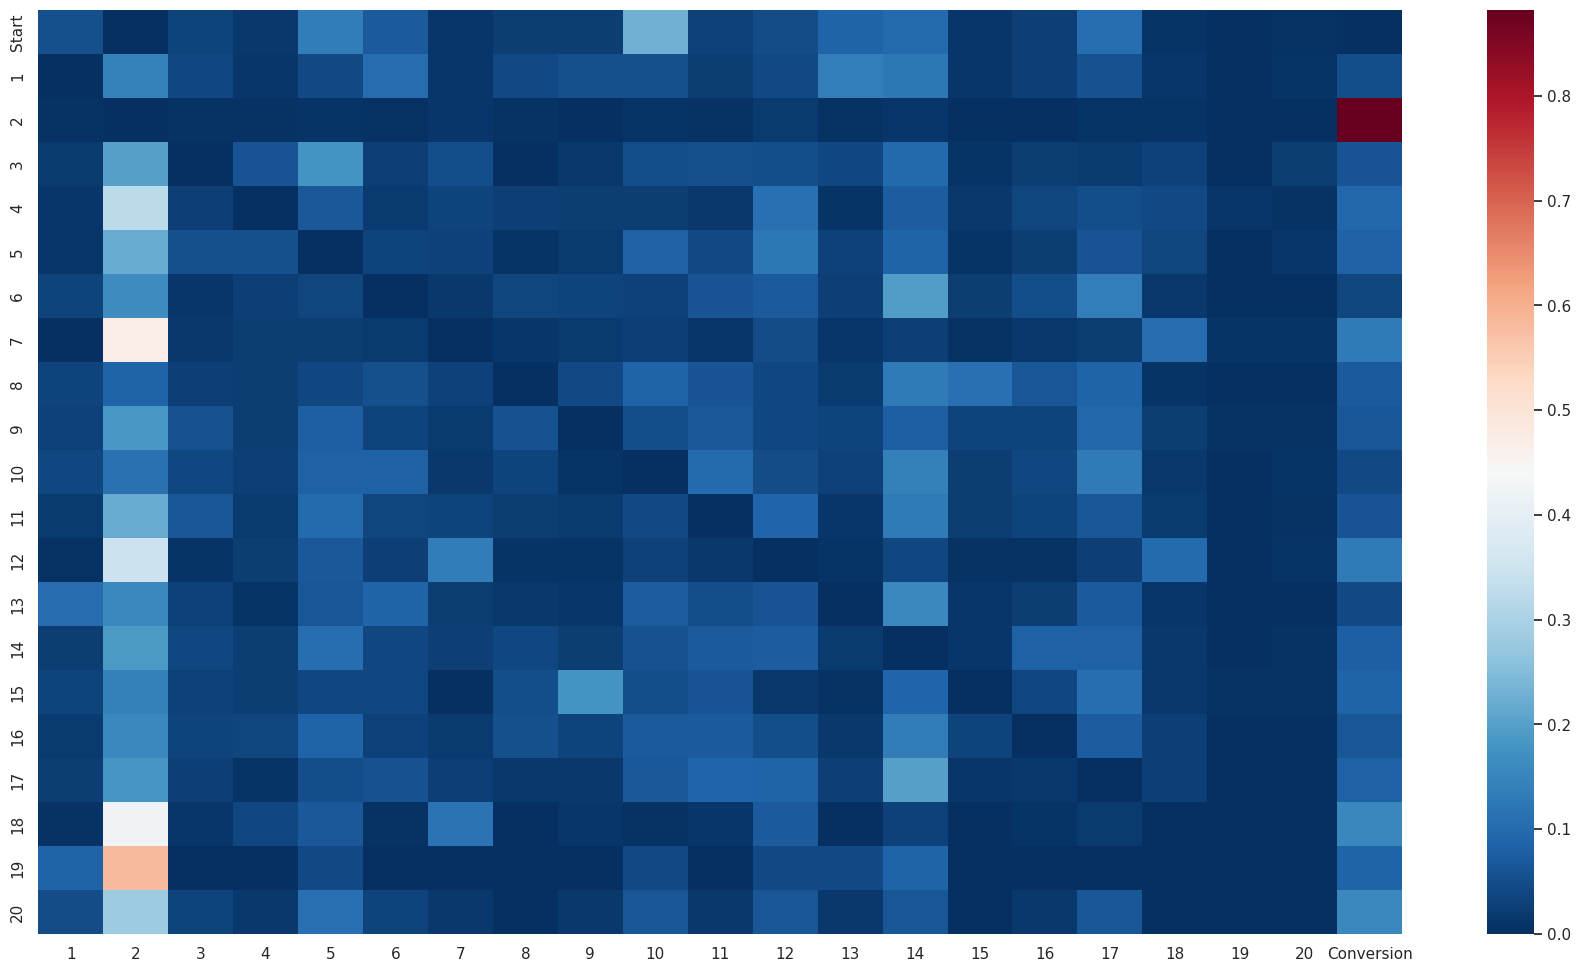

In [32]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(trans_matrix, cmap="RdBu_r")
plt.show()

### Conclusion: A Markov chain approach will look to model channel attribution by accounting for how a user journey data is structured.

### Analyzing the output of the Markov chain model gives us a “snapshot” of marketing channel effectiveness, at a specific point in time. We might be able to gain extra insights by looking at the model output for data just before and after a new marketing campaign launch, giving us essential information on how the campaign affected the performance of each channel.